In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random
import math
from math import sin, cos
import nibabel as nib

C:\Users\user\anaconda3\envs\Synthseg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# torch.nn.functional.grid_sample() distortion

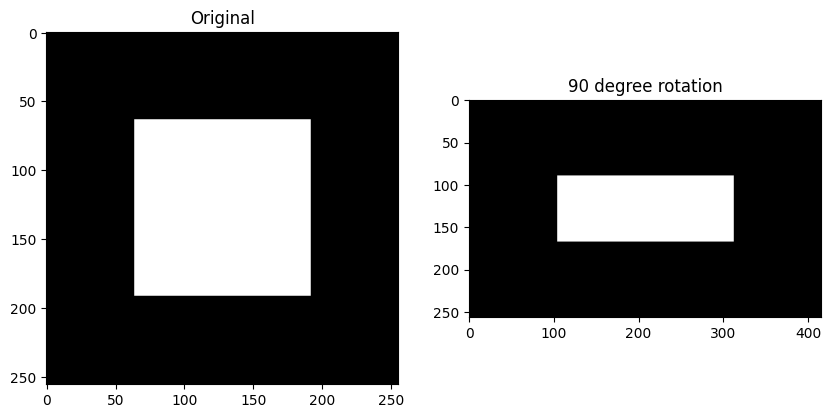

In [24]:
img = torch.zeros((256, 256))
img[64:192, 64:192] = 1

a = math.radians(90)
affine = torch.tensor([[cos(a), -sin(a), 0],
                       [sin(a),  cos(a), 0]])[None, ...]

grid = F.affine_grid(affine, img[None, None, ...].size(), align_corners=False)
new_img = F.grid_sample(img[None, None, ...], grid, mode='nearest', align_corners=False)[0, 0, ...]
plt.figure(figsize=(10, 20))
plt.subplot(121)
plt.title("Original")
plt.imshow(new_img, cmap="gray")
plt.subplot(122)
plt.title("90 degree rotation")
plt.imshow(new_img2, cmap="gray")
plt.show()

# 2D Nonlinear Deform

In [104]:
img = nib.load("samseg.nii.gz").get_fdata()
img = torch.from_numpy(img).float()
img = img[70, :, :]

def make_grid(grid_size, gap):
    grid = torch.zeros(grid_size)
    
    for i in range(0, grid.shape[0], gap):
        grid[i, :] = 1
    for j in range(0, grid.shape[1], gap):
        grid[:, j] = 1
        
    return grid

grid_img = make_grid((256, 256), 16)

In [105]:
# make 2D coordinate grid
x, y = torch.meshgrid(torch.linspace(-1, 1, steps=img.shape[0]), torch.linspace(-1, 1, steps=img.shape[1]), indexing="ij")

# svf = torch.zeros((img.shape[0], img.shape[1], 2))
# svf[:, :, 0] = 64 / 256 * 2
# svf[:, :, 1] = 64 / 256 * 2
std_svf = random.uniform(4, 4) # sample standard deviation
svf = torch.normal(0, std_svf, (2, 10, 10)) # 10x10x10x3 simple vector field sampled from Gaussian Distribution
svf = F.interpolate(svf[None, ...], size=img.size(), mode="bilinear")[0, ...] # upsample to image size
svf1 = torch.exp(svf)
svf  = svf / 256 * 2
svf1  = svf1 / 256 * 2
svf = svf.permute((1, 2, 0))
svf1 = svf1.permute((1, 2, 0))

grid = torch.stack((x, y), dim=-1).float()
grid1 = grid - svf1
grid = grid - svf
grid = grid.permute((1, 0, 2))
grid1 = grid1.permute((1, 0, 2))

**deform visualize**

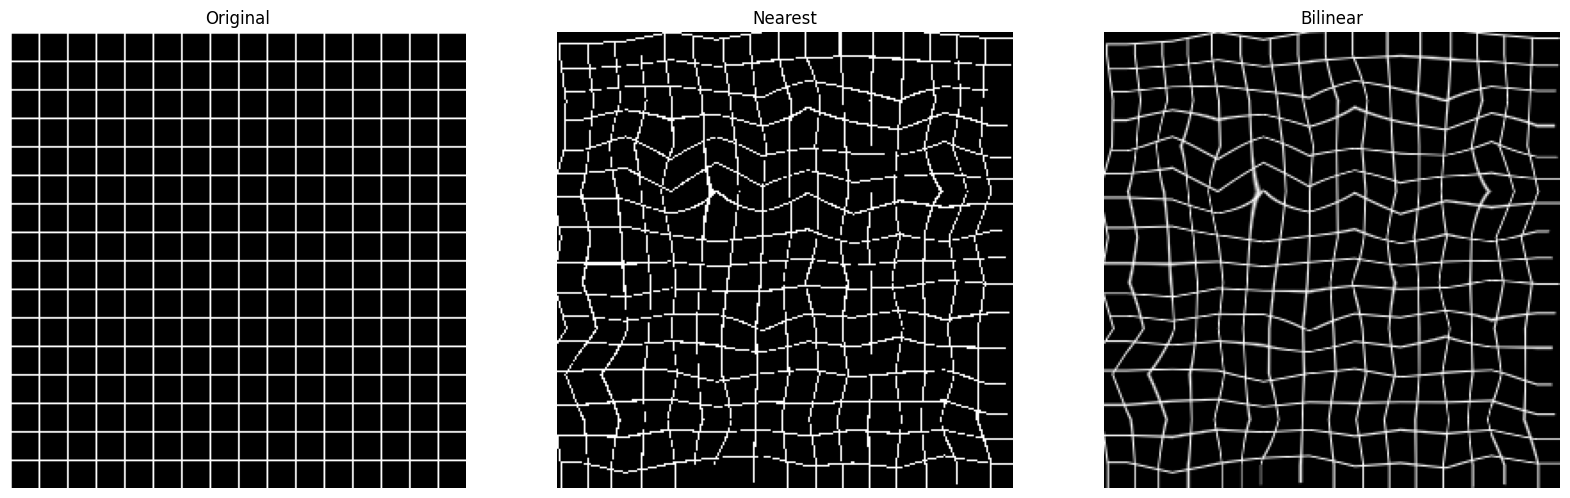

In [106]:
a = F.grid_sample(grid_img[None, None, ...], grid[None, ...], mode='nearest', align_corners=False)[0, 0, ...]
b = F.grid_sample(grid_img[None, None, ...], grid[None, ...], mode='bilinear', align_corners=False)[0, 0, ...]

cmap = "gray"
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.title("Original")
plt.imshow(grid_img, cmap=cmap)
plt.axis("off")
plt.subplot(132)
plt.title("Nearest")
plt.imshow(a, cmap=cmap)
plt.axis("off")
plt.subplot(133)
plt.title("Bilinear")
plt.imshow(b, cmap=cmap)
plt.axis("off")
plt.show()

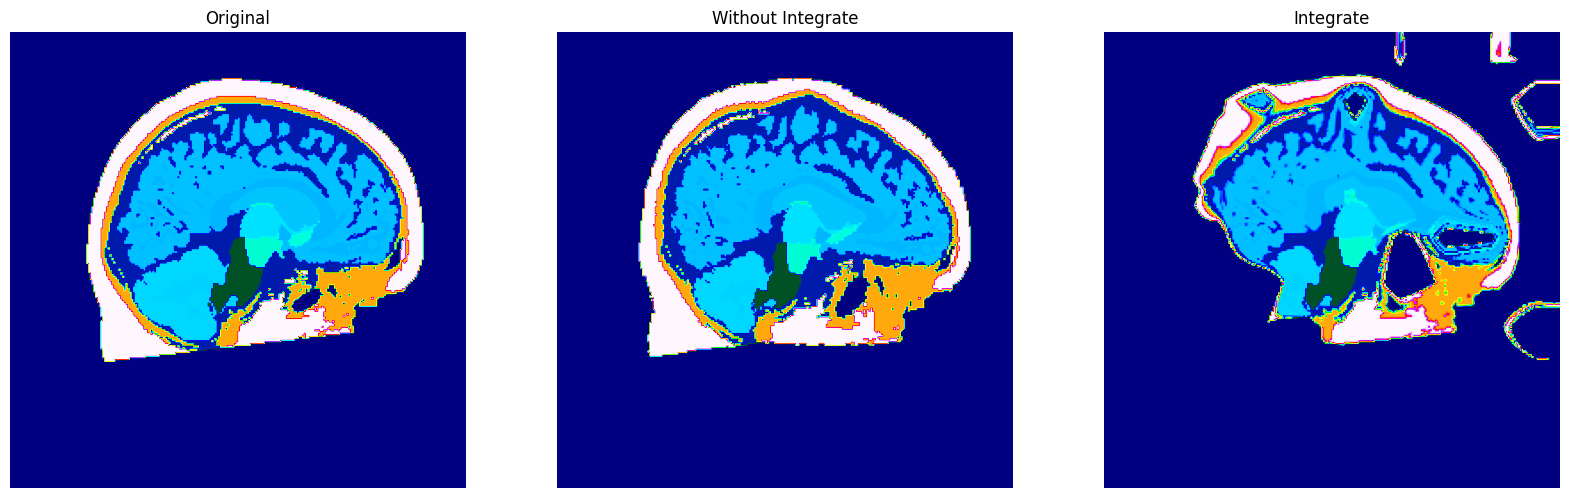

In [38]:
a = F.grid_sample(img[None, None, ...], grid[None, ...], mode='nearest', align_corners=False)[0, 0, ...]
b = F.grid_sample(img[None, None, ...], grid1[None, ...], mode='bilinear', align_corners=False)[0, 0, ...]
plt.figure(figsize=(20, 20))

cmap  = "gist_ncar"
plt.subplot(131)
plt.title("Original")
plt.imshow(np.rot90(img), cmap=cmap)
plt.axis("off")
plt.subplot(132)
plt.title("Without Integrate")
plt.imshow(np.rot90(a), cmap=cmap)
plt.axis("off")
plt.subplot(133)
plt.title("Integrate")
plt.imshow(np.rot90(b), cmap=cmap)
plt.axis("off")
plt.show()

# 3D

In [119]:
img = nib.load("samseg.nii.gz").get_fdata()
img = torch.from_numpy(img).float()
print("original:      ", img.shape)

original:       torch.Size([160, 256, 256])


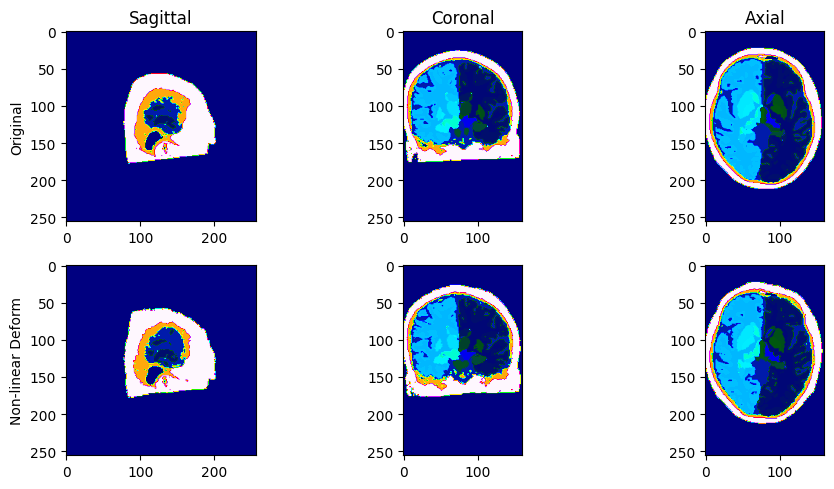

In [121]:
def nonlinear_deform(image, max_std=4):
    # make 3D coordinate grid
    image = F.pad(image, pad=(0, 0, 0, 0, 48, 48))
    x, y, z = torch.meshgrid(torch.linspace(-1, 1, steps=image.shape[0]),
                             torch.linspace(-1, 1, steps=image.shape[1]),
                             torch.linspace(-1, 1, steps=image.shape[2]), indexing="ij")

    std_svf = random.uniform(0, max_std) # sample standard deviation
    svf = torch.normal(0, std_svf, (3, 10, 10, 10)) # 3x10x10x10 simple vector field sampled from Gaussian Distribution
    svf = F.interpolate(svf[None, ...], size=image.size(), mode="trilinear")[0, ...] # upsample to image size
    svf  = svf / 256 * 2 # rescale
    svf = svf.permute((1, 2, 3, 0))

    grid = torch.stack((x, y, z), dim=-1).float()
    grid = grid - svf
    grid = grid.permute((2, 1, 0, 3))

    deformed_image = F.grid_sample(image[None, None, ...], grid[None, ...], mode='nearest', align_corners=False)[0, 0, ...]
    return deformed_image[48:-48, :, :]

a = nonlinear_deform(img)

cmap = "gist_ncar"
plt.figure(figsize=(10, 5))

plt.subplot(231)
plt.title("Sagittal")
plt.ylabel("Original")
plt.imshow(np.rot90(img[140, :, :]), cmap=cmap)
plt.subplot(232)
plt.title("Coronal")
plt.imshow(np.rot90(img[:, 140, :]), cmap=cmap)
plt.subplot(233)
plt.title("Axial")
plt.imshow(np.rot90(img[:, :, 140]), cmap=cmap)


plt.subplot(234)
plt.ylabel("Non-linear Deform")
plt.imshow(np.rot90(a[140, :, :]), cmap=cmap)
plt.subplot(235)
plt.imshow(np.rot90(a[:, 140, :]), cmap=cmap)
plt.subplot(236)
plt.imshow(np.rot90(a[:, :, 140]), cmap=cmap)

plt.tight_layout()
plt.show()

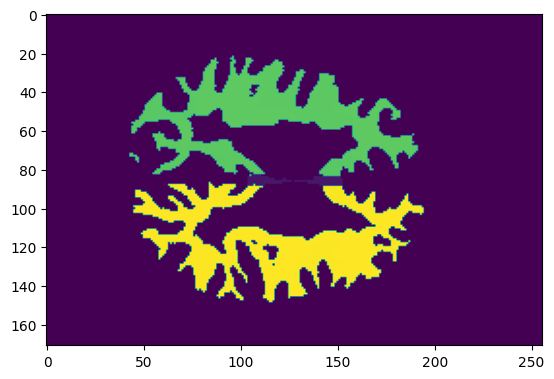

array([   0.,  251.,  252.,  253.,  254.,  255., 3001., 3002., 3003.,
       3005., 3006., 3007., 3008., 3009., 3010., 3011., 3012., 3013.,
       3014., 3015., 3016., 3017., 3018., 3019., 3020., 3021., 3022.,
       3023., 3024., 3025., 3026., 3027., 3028., 3029., 3030., 3031.,
       3032., 3033., 3034., 3035., 4001., 4002., 4003., 4005., 4006.,
       4007., 4008., 4009., 4010., 4011., 4012., 4013., 4014., 4015.,
       4016., 4017., 4018., 4019., 4020., 4021., 4022., 4023., 4024.,
       4025., 4026., 4027., 4028., 4029., 4030., 4031., 4032., 4033.,
       4034., 4035.])

In [13]:
a = nib.load("CC0001_philips_15_55_M_wmp.nii.gz").get_fdata()
plt.figure()
plt.imshow(a[:, :, 140])
plt.show()
np.unique(a)